**MBAN 6120 Assignment 3**

1. Model Architecture Choice
I chose four models for the image classification, alexnet model, vgg model, inception model and resnet model.

-alexnet is suitable for simple architeture, and vgg is more suitable for uniform architeture but might be underperform.
inception model tends to have higher accuracy than other models, but is more complex and resource intensive.
resnet model is more suitable for deep neetworks, but might overfit in smaller dataset.
2. Challenges
I found it hard for some models to improve accuracy even though I made lots of efforts. Memory storage is another problem I encoutered. I worked in colab and my storage went out when I was trying to improve accuracy. I implemented early stopping and so the model can use less storage and i can run more codes.

3. Results
The most efficient model is inception model, the accuracy score improved significantly to about 81.08% after fine tuning. However, as the accuracy is too high there might be overfitting problems.
Other models remain low accuarcy, the accuarcy improved a little bit after fine tuning but not as significant as inception mode..
alexnet model accuarcy is about 0.58%. After fine tuning the model, it can achieve 27% but I deleted it because of storate memory. however, this might lead to overfitting as the improvement is a lot.
vgg model accuarcy is about 0.42%.
inception model accuarcy is ababout 0.58% but after ttuning it became 81.08%
resnet model accuracy is about 3.42%.


4. Insights and Learnings
alexnet and vgg: They showed relatively low performance. This could be due to their simpler structures (in the case of AlexNet) or very deep architectures without sophisticated mechanisms to avoid overfitting (as in VGG).

In [38]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization



In [39]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)



In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir=PosixGPath('/tmp/tmpxud5gb7ptfds'),
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(sh

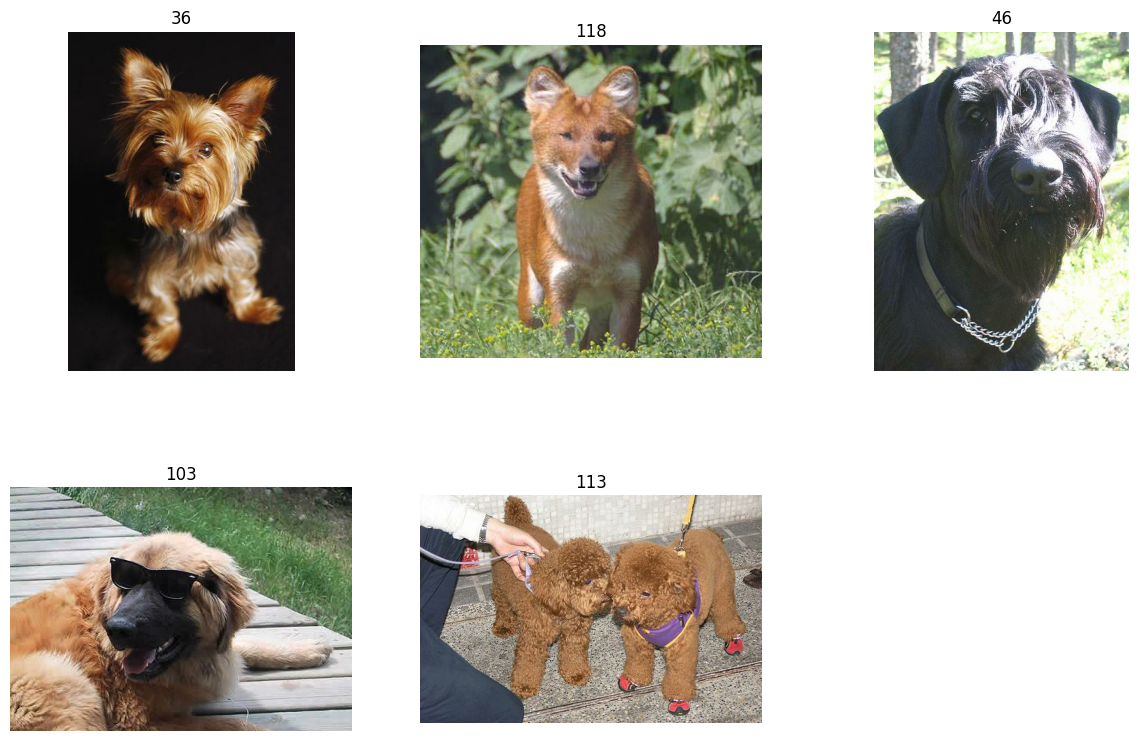

In [4]:
def show_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(int(label))
        plt.axis("off")

show_images(ds_train)

In [5]:
for image, label in ds_train.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Image data type: {image.dtype}")
    print(f"Label: {label}")


Image shape: (500, 333, 3)
Image data type: <dtype: 'uint8'>
Label: 36


In [6]:
class_names = ds_info.features['label'].names
print(class_names)

['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshire_t

In [7]:
def preprocess(image, label):
    # Resize images to a consistent size
    image = tf.image.resize(image, [224, 224])
    # Normalize pixel values
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_validation = ds_validation.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
# Iterate through the preprocessed dataset and print the shape of the first few images
for image_batch, label_batch in ds_train.take(1):
    for i in range(5):
        print(f"Image {i+1} shape: {image_batch[i].shape}")


Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Image 5 shape: (224, 224, 3)


Model Building

In [9]:
model = tf.keras.models.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # More layers (experiment with number and size)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])


In [10]:
# Define the AlexNet model
def AlexNet(input_shape=(224, 224, 3), num_classes=ds_info.features['label'].num_classes):
    model = Sequential([
        Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, kernel_size=(3, 3), activation='relu'),
        Conv2D(384, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

alexnet_model = AlexNet()


In [16]:
alexnet_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)


In [13]:
alexnet_history = alexnet_model.fit(ds_train,
                                    epochs=10,
                                    validation_data=ds_validation,
                                    callbacks=[early_stopping, checkpoint])


Epoch 1/10
300/300 [==============================] - 19s 63ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7935 - val_accuracy: 0.0042
Epoch 2/10
300/300 [==============================] - 22s 75ms/step - loss: 4.7874 - accuracy: 0.0089 - val_loss: 4.7941 - val_accuracy: 0.0042
Epoch 3/10
300/300 [==============================] - 19s 63ms/step - loss: 4.7874 - accuracy: 0.0082 - val_loss: 4.7948 - val_accuracy: 0.0042
Epoch 4/10
300/300 [==============================] - 20s 66ms/step - loss: 4.7873 - accuracy: 0.0085 - val_loss: 4.7953 - val_accuracy: 0.0042


In [19]:
test_loss, test_accuracy = alexnet_model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


38/38 [==============================] - 5s 87ms/step - loss: 4.7943 - accuracy: 0.0058
Test Accuracy: 0.58%


In [20]:
# Example: Modifying the Dense layer of VGG
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = Flatten()(vgg_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

# Configure and compile the model
vgg_model = Model(inputs=vgg_model.input, outputs=predictions)

vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [21]:
vgg_history = vgg_model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation,
    callbacks=[early_stopping, checkpoint]
)

test_loss, test_accuracy = vgg_model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 4.8354 - accuracy: 0.0069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 147s 437ms/step - loss: 4.8354 - accuracy: 0.0069 - val_loss: 4.7891 - val_accuracy: 0.0058
Epoch 2/10
300/300 [==============================] - 124s 414ms/step - loss: 4.7880 - accuracy: 0.0069 - val_loss: 4.7906 - val_accuracy: 0.0075
Epoch 3/10
300/300 [==============================] - 123s 410ms/step - loss: 4.7879 - accuracy: 0.0071 - val_loss: 4.7917 - val_accuracy: 0.0067
Epoch 4/10
300/300 [==============================] - 123s 411ms/step - loss: 4.7877 - accuracy: 0.0091 - val_loss: 4.7928 - val_accuracy: 0.0067


In [22]:
test_loss, test_accuracy = vgg_model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

38/38 [==============================] - 5s 123ms/step - loss: 4.7922 - accuracy: 0.0042
Test Accuracy: 0.42%


In [24]:
# Load the InceptionV3 model pre-trained on ImageNet
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = Flatten()(inception_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

# Construct the final model
inception_model_final = Model(inputs=inception_model.input, outputs=x)


87910968/87910968 [==============================] - 0s 0us/step


In [25]:
inception_model_final.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

for layer in inception_model.layers:
    layer.trainable = False

inception_history = inception_model_final.fit(ds_train,
                                              epochs=10,
                                              validation_data=ds_validation,
                                              callbacks=[early_stopping, checkpoint])

test_loss, test_accuracy = inception_model_final.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 5.0533 - accuracy: 0.0078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 126s 297ms/step - loss: 5.0533 - accuracy: 0.0078 - val_loss: 4.7885 - val_accuracy: 0.0067
Epoch 2/10
300/300 [==============================] - 79s 264ms/step - loss: 4.7891 - accuracy: 0.0065 - val_loss: 4.7899 - val_accuracy: 0.0050
Epoch 3/10
300/300 [==============================] - 78s 259ms/step - loss: 4.7882 - accuracy: 0.0077 - val_loss: 4.7916 - val_accuracy: 0.0042
Epoch 4/10
38/38 [==============================] - 3s 70ms/step - loss: 4.7916 - accuracy: 0.0058
Test Accuracy: 0.005833333358168602


another inception model

In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load the InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

# Construct the final model
inception_model_final = Model(inputs=base_model.input, outputs=predictions)


In [27]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.0001)
inception_model_final.compile(optimizer=optimizer,
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])


In [28]:
history = inception_model_final.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation,
    callbacks=[early_stopping, checkpoint]
)

test_loss, test_accuracy = inception_model_final.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
300/300 [==============================] - 34s 96ms/step - loss: 3.4773 - accuracy: 0.2699 - val_loss: 1.1665 - val_accuracy: 0.7375
Epoch 2/10
300/300 [==============================] - 28s 92ms/step - loss: 1.4313 - accuracy: 0.6449 - val_loss: 0.7582 - val_accuracy: 0.7883
Epoch 3/10
300/300 [==============================] - 30s 98ms/step - loss: 1.0443 - accuracy: 0.7226 - val_loss: 0.6986 - val_accuracy: 0.7958
Epoch 4/10
300/300 [==============================] - 30s 99ms/step - loss: 0.9140 - accuracy: 0.7483 - val_loss: 0.6807 - val_accuracy: 0.7950
Epoch 5/10
300/300 [==============================] - 27s 89ms/step - loss: 0.8355 - accuracy: 0.7676 - val_loss: 0.6666 - val_accuracy: 0.8008
Epoch 6/10
300/300 [==============================] - 31s 102ms/step - loss: 0.7705 - accuracy: 0.7816 - val_loss: 0.6671 - val_accuracy: 0.7958
Epoch 7/10
300/300 [==============================] - 27s 91ms/step - loss: 0.7156 - accuracy: 0.7928 - val_loss: 0.6533 - val_accuracy

In [31]:
# Assuming ds_test is your test dataset
true_labels = []
for images, labels in ds_test:
    true_labels.extend(labels.numpy())

y_true = np.array(true_labels)

38/38 [==============================] - 2s 43ms/step


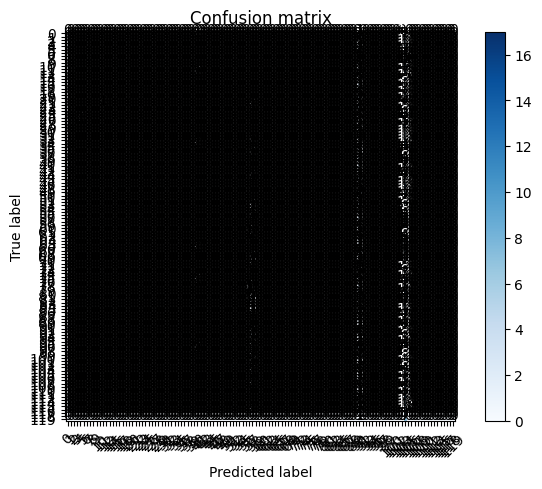

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
Y_pred = model.predict(ds_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(ds_info.features['label'].num_classes))

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model


94765736/94765736 [==============================] - 0s 0us/step


In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can experiment with the number of neurons
x = Dense(512, activation='relu')(x)  # Additional dense layer
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [35]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [36]:
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation
)
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
300/300 [==============================] - 38s 109ms/step - loss: 4.8071 - accuracy: 0.0079 - val_loss: 4.7891 - val_accuracy: 0.0108
Epoch 2/10
300/300 [==============================] - 32s 105ms/step - loss: 4.7869 - accuracy: 0.0085 - val_loss: 4.7827 - val_accuracy: 0.0092
Epoch 3/10
300/300 [==============================] - 32s 106ms/step - loss: 4.7510 - accuracy: 0.0144 - val_loss: 4.7585 - val_accuracy: 0.0083
Epoch 4/10
300/300 [==============================] - 34s 114ms/step - loss: 4.7198 - accuracy: 0.0148 - val_loss: 4.7381 - val_accuracy: 0.0092
Epoch 5/10
300/300 [==============================] - 33s 110ms/step - loss: 4.7032 - accuracy: 0.0141 - val_loss: 4.7268 - val_accuracy: 0.0083
Epoch 6/10
300/300 [==============================] - 34s 112ms/step - loss: 4.6946 - accuracy: 0.0137 - val_loss: 4.7208 - val_accuracy: 0.0092
Epoch 7/10
300/300 [==============================] - 35s 115ms/step - loss: 4.6862 - accuracy: 0.0144 - val_loss: 4.7166 - val_ac

another resnet model as the accuracy is not desire

In [40]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Example of a deeper architecture
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Further layers can be added here, experiment with different sizes
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [44]:
def preprocess(image, label):
    # Resize the image to 224x224 pixels
    image = tf.image.resize(image, [224, 224])
    # Normalize the image
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation
)

test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
300/300 [==============================] - 46s 119ms/step - loss: 5.7457 - accuracy: 0.0124 - val_loss: 4.8228 - val_accuracy: 0.0117
Epoch 2/10
300/300 [==============================] - 35s 118ms/step - loss: 5.3866 - accuracy: 0.0168 - val_loss: 4.8176 - val_accuracy: 0.0200
Epoch 3/10
300/300 [==============================] - 34s 112ms/step - loss: 5.2408 - accuracy: 0.0204 - val_loss: 4.8515 - val_accuracy: 0.0258
Epoch 4/10
300/300 [==============================] - 35s 118ms/step - loss: 5.0979 - accuracy: 0.0242 - val_loss: 4.8572 - val_accuracy: 0.0250
Epoch 5/10
300/300 [==============================] - 34s 113ms/step - loss: 5.0148 - accuracy: 0.0301 - val_loss: 4.8172 - val_accuracy: 0.0258
Epoch 6/10
300/300 [==============================] - 35s 117ms/step - loss: 4.9227 - accuracy: 0.0338 - val_loss: 4.8513 - val_accuracy: 0.0250
Epoch 7/10
300/300 [==============================] - 35s 117ms/step - loss: 4.8460 - accuracy: 0.0346 - val_loss: 4.8412 - val_ac

In [ ]:
# Assuming ds_test is your test dataset
true_labels = []
for images, labels in ds_test:
    true_labels.extend(labels.numpy())

y_true = np.array(true_labels)


38/38 [==============================] - 5s 94ms/step


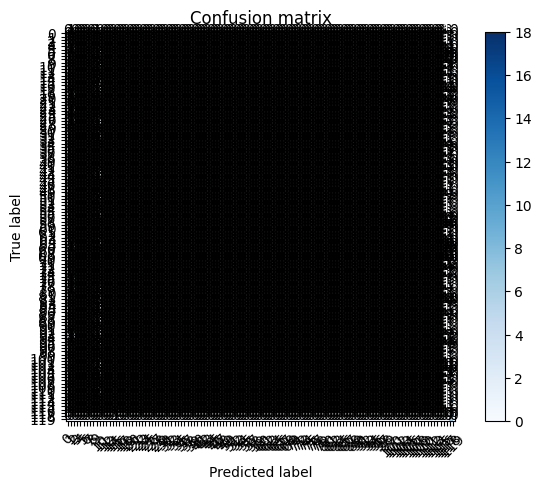

In [48]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
Y_pred = model.predict(ds_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(ds_info.features['label'].num_classes))
